##Class Activation Map

In [1]:
import fastai
from fastai import *
from fastai.vision import *
import numpy as np

import PIL

In [2]:
classes = ['alligator', 'crocodile']

In [3]:
path = Path("data")
data = ImageDataBunch.single_from_classes(path, classes, tfms=get_transforms(), size=224).normalize(imagenet_stats)
learn = create_cnn(data, models.resnet34)
MODEL = "stage-2.pth"


In [4]:
# learn.model[0][-1][-1]
learn.model[0][4], "----><-----", learn.model[0][-1][0]

(Sequential(
   (0): BasicBlock(
     (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
     (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
     (relu): ReLU(inplace)
     (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
     (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
   )
   (1): BasicBlock(
     (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
     (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
     (relu): ReLU(inplace)
     (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
     (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
   )
   (2): BasicBlock(
     (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
     (bn1): BatchNorm2d(64, eps=1e-

In [5]:
# target_layer = learn.model[0][-1][-1]
target_layer = learn.model[0][-1][0]

fmap_hook = fastai.callbacks.hook_output(target_layer)
def gradient_torch_hook(self, grad_input, grad_output):
    return grad_input

gradient_hook = fastai.callbacks.Hook(target_layer, gradient_torch_hook, is_forward=False)

learn.model.eval();

learn.model.load_state_dict(
    torch.load("data/models/%s" % MODEL, map_location="cpu")
)

In [6]:
target_layer

BasicBlock(
  (conv1): Conv2d(256, 512, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
  (bn1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace)
  (conv2): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn2): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (downsample): Sequential(
    (0): Conv2d(256, 512, kernel_size=(1, 1), stride=(2, 2), bias=False)
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
)

In [7]:
fname = 'data/croc.jpg'

In [8]:
img = open_image(fname)
pred_class, pred_idx, outputs = learn.predict(img)

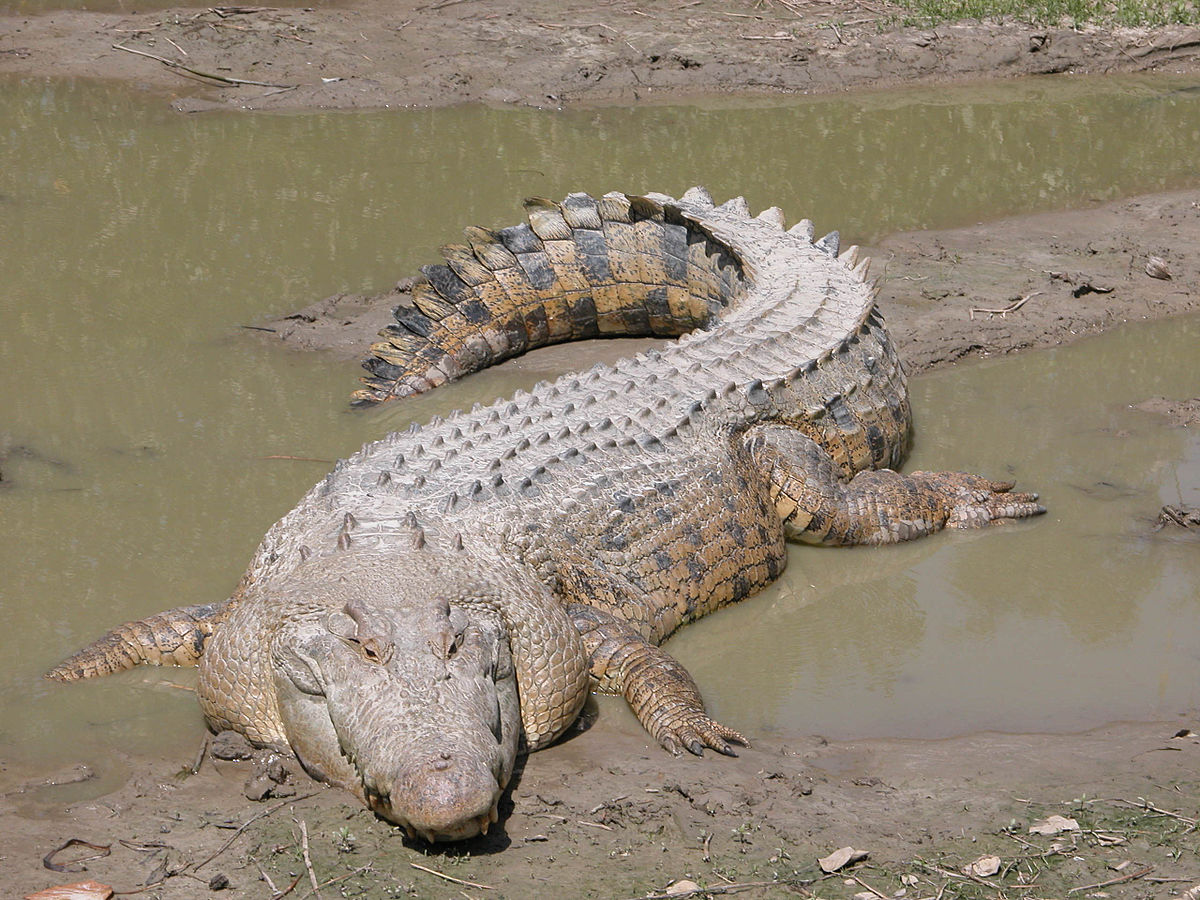

'crocodile'

tensor(1)

tensor([0.2104, 7.7744])

In [9]:
display(img); display(pred_class); display(pred_idx); display(outputs)

In [10]:
learn.model.eval()
learn.data.valid_ds.set_item(img)

In [11]:
 gradient_hook.stored

In [12]:
upsampledL = []

tensor_img = list(learn.dl())[0][0]
out = learn.model(tensor_img); out

tensor([[-1.5589,  2.0508]], device='cuda:0', grad_fn=<ThAddmmBackward>)

In [13]:
# argsort in reverse (negative tensor)
sort_idx = np.argsort(-out.cpu())[0]

from skimage.transform import resize
import scipy

vals_min = []
vals_max = []

In [14]:
sort_idx

tensor([1, 0])

In [15]:
for i in range(2):
    # get gradients for predicted class
    onehot = torch.zeros(data.c) # setup empty tensor based on number of classes

    onehot[i] = 1
    print(onehot)
    #onehot[torch.argmax(out)] = 1. # one-hot-encode predicted class
    
    out.backward(gradient=onehot.reshape(1, -1).cuda(), retain_graph=True) # backpropagate onehot encoding to get gradients

    gradients = next(iter(gradient_hook.stored))
    print("Gradients: ", gradients.shape)
    gradient_linearization = gradients.cpu().numpy().sum((2, 3)).reshape(-1) # sum up gradients and linearize
    
    _, n, w, h = gradients.shape

    fmaps = fmap_hook.stored.cpu().numpy().reshape(n, w, h) # reshape activations
    heatmap = np.maximum(0, np.einsum('i, ijk', gradient_linearization, fmaps)) # multiply summed gradients with the gradients to get the heatmap
    
    heatmap_299 = scipy.ndimage.interpolation.zoom(heatmap, (224 / 10, 224 / 10), order=3)
    print(heatmap_299.shape)
    upsampledL.append(heatmap_299)

tensor([1., 0.])
Gradients:  torch.Size([1, 512, 7, 7])
(157, 157)
tensor([0., 1.])
Gradients:  torch.Size([1, 512, 7, 7])
(157, 157)


/home/nbuser/.anaconda3/lib/python3.7/site-packages/scipy/ndimage/interpolation.py:583: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)


In [16]:
import matplotlib.colors as c
cmapIn = plt.get_cmap('hot_r')

minval = 0
maxval = 0.9
new_cmap = c.LinearSegmentedColormap.from_list(
    'trunc({n},{a:.2f},{b:.2f})'.format(n=cmapIn.name, a=minval, b=maxval),
    cmapIn(np.linspace(minval, maxval, n)))

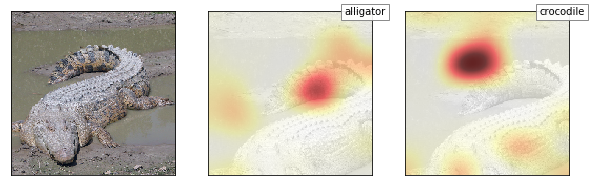

In [17]:

t = np.transpose(tensor_img.squeeze(), (1, 2, 0))
t = (t - t.min()) / (t.max() - t.min())


fig, axes = plt.subplots(1, 3, figsize=(10,8))

min_all = min([x.min() for x in upsampledL])
max_all = max([x.max() for x in upsampledL])

bbox_props = dict(boxstyle="square", fc="w", ec="0.5", alpha=0.9)


# iterate over all classes and plot grad-CAM for each
for i, ax in enumerate(axes.flat):
    if i == 0:
        ax.imshow(t.numpy())
    else:
        ax.imshow(t[...,2], cmap="Greys_r", alpha=.25)

        up = (upsampledL[i-1][...,np.newaxis]-min_all) / max_all
        colors = new_cmap((upsampledL[i-1]-min_all) / max_all)

        # set alpha
        colors[..., -1] = up.squeeze() * 0.75 
        ax.imshow(colors)
        
        lab = classes[i-1]
        ax.text(150, 0, lab, ha="center", va="center", size=10, bbox=bbox_props)

    ax.get_xaxis().set_ticks([])
    ax.get_yaxis().set_ticks([])
plt.savefig('cam.png', bbox_inches='tight')